In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Step 1: Load the pairwise similarity file
df = pd.read_excel("/Users/jessicakamal/pairwise_similarity.xlsx")

# Step 2: Extract all unique tweets
tweets = pd.unique(df[['Tweet 1', 'Tweet 2']].values.ravel())
tweet_index = {tweet: idx for idx, tweet in enumerate(tweets)}

# Step 3: Initialize similarity matrix
n = len(tweets)
similarity_matrix = np.zeros((n, n))

# Step 4: Fill matrix using similarity scores
for _, row in df.iterrows():
    i = tweet_index[row['Tweet 1']]
    j = tweet_index[row['Tweet 2']]
    similarity = float(row['Similarity Score'])
    similarity_matrix[i, j] = similarity
    similarity_matrix[j, i] = similarity  # Symmetric

# Step 5: Threshold the matrix
threshold = 0.32
similarity_matrix_thresholded = np.where(similarity_matrix >= threshold, similarity_matrix, 0)

# Step 6: Apply LSA
n_components = min(5, similarity_matrix_thresholded.shape[1])
svd = TruncatedSVD(n_components=n_components)
lsa_matrix = svd.fit_transform(similarity_matrix_thresholded)

# Step 7: Rank and select top 25 representative tweets
scores = np.linalg.norm(lsa_matrix, axis=1)
top_indices = np.argsort(scores)[::-1][:25]
lsa_summary = [tweets[i] for i in top_indices]

# Step 8: Save to Excel
lsa_summary_df = pd.DataFrame(lsa_summary)
lsa_summary_df.to_excel("/Users/jessicakamal/LSAsummary.xlsx", index=False, header=False)

print("✅ LSA summary saved to LSAsummary.xlsx")


✅ LSA summary saved to LSAsummary.xlsx


🧔 Male Mentions: 8
👩 Female Mentions: 20
📊 Bias Score (female - male): 0.43
🟣 The summary is biased toward females.


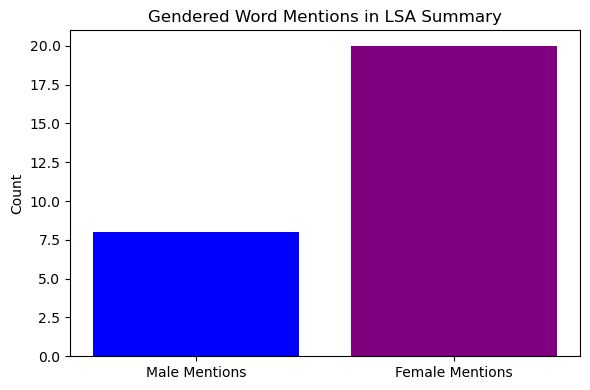

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load summary ===
lsa_summary_df = pd.read_excel("/Users/jessicakamal/LSAsummary.xlsx", header=None)
lsa_summary_text = " ".join(lsa_summary_df[0].astype(str).tolist()).lower()

# === Load gender term lists ===
male_terms = pd.read_csv("/Users/jessicakamal/male_list.csv", header=None)[0].str.lower().tolist()
female_terms = pd.read_csv("/Users/jessicakamal/female_list.csv", header=None)[0].str.lower().tolist()

# === Gender mention counter ===
def count_gender_terms(text, male_terms, female_terms):
    words = text.lower().split()
    male_count = sum(word in male_terms for word in words)
    female_count = sum(word in female_terms for word in words)
    return male_count, female_count

# === Count and calculate bias ===
male_count, female_count = count_gender_terms(lsa_summary_text, male_terms, female_terms)
total = male_count + female_count

if total > 0:
    male_ratio = male_count / total
    female_ratio = female_count / total
    bias_score = female_ratio - male_ratio
else:
    male_ratio = female_ratio = bias_score = 0

# === Results ===
print(f"🧔 Male Mentions: {male_count}")
print(f"👩 Female Mentions: {female_count}")
print(f"📊 Bias Score (female - male): {bias_score:.2f}")

if bias_score > 0:
    print("🟣 The summary is biased toward females.")
elif bias_score < 0:
    print("🔵 The summary is biased toward males.")
else:
    print("⚪ The summary appears neutral.")

# === Plot ===
plt.figure(figsize=(6, 4))
plt.bar(['Male Mentions', 'Female Mentions'], [male_count, female_count], color=['blue', 'purple'])
plt.title('Gendered Word Mentions in LSA Summary')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
